In [27]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import lmfit
from lmfit.models import LinearModel, LorentzianModel
from uncertainties import unumpy as up
from uncertainties import ufloat
from uncertainties import wrap
from pathlib import Path

In [28]:
def voigt1(x,s1,g1,o1,scale1):
    return scale1*scipy.special.voigt_profile(x-o1,s1,g1)
def voigt2(x,s1,s2,g1,g2,o1,o2,scale1,scale2,c):
    return scale1*scipy.special.voigt_profile(x-o1,s1,g1)+scale2*scipy.special.voigt_profile(x-o2,s2,g2)+c

In [29]:
def dez(isig,inoise):
    return 10*np.log10(isig/inoise)


def FWHM(s_p,g_p):
    s = ufloat(s_p.value,s_p.stderr)
    g = ufloat(g_p.value,g_p.stderr)
    fg=s*(8*up.log(2))**0.5
    fl=2*g
    return 0.5346*fl+((fg)**2+(0.2166*fl**2))**0.5

def uvoigt1(out_voigt):
    x_p,s1_p,g1_p,o1_p,scale1_p=out_voigt.result.params['o1'],out_voigt.result.params['s1'],out_voigt.result.params['g1'],out_voigt.result.params['o1'],out_voigt.result.params['scale1']
    x = ufloat(x_p.value,x_p.stderr)
    s1 = ufloat(s1_p.value,s1_p.stderr)
    g1 = ufloat(g1_p.value,g1_p.stderr)
    o1 = ufloat(o1_p.value,o1_p.stderr)
    scale1 = ufloat(scale1_p.value,scale1_p.stderr)
    uv=wrap(voigt1)
    return uv(x,s1,g1,o1,scale1)

def uvoigt2(out_voigt):
    x1_p,s1_p,g1_p,o1_p,scale1_p=out_voigt.result.params['o1'],out_voigt.result.params['s1'],out_voigt.result.params['g1'],out_voigt.result.params['o1'],out_voigt.result.params['scale1']
    x2_p,s2_p,g2_p,o2_p,scale2_p=out_voigt.result.params['o2'],out_voigt.result.params['s2'],out_voigt.result.params['g2'],out_voigt.result.params['o2'],out_voigt.result.params['scale2']
    x1 = ufloat(x1_p.value,x1_p.stderr)
    s1 = ufloat(s1_p.value,s1_p.stderr)
    g1 = ufloat(g1_p.value,g1_p.stderr)
    o1 = ufloat(o1_p.value,o1_p.stderr)
    scale1 = ufloat(scale1_p.value,scale1_p.stderr)
    x2 = ufloat(x2_p.value,x2_p.stderr)
    s2 = ufloat(s2_p.value,s2_p.stderr)
    g2 = ufloat(g2_p.value,g2_p.stderr)
    o2 = ufloat(o2_p.value,o2_p.stderr)
    scale2 = ufloat(scale2_p.value,scale2_p.stderr)


    uv=wrap(voigt2)

    p1 = uv(x1,s1,s2,g1,g2,o1,o2,scale1,scale2)
    p2 = uv(x2,s1,s2,g1,g2,o1,o2,scale1,scale2)
    return p1,p2

def uvoigt(out_voigt):
    try:
        return uvoigt2(out_voigt)
    except:
        return uvoigt1(out_voigt)

In [30]:
def SNR(res):
    s1 = ufloat(res.result.params['s1'].value,res.result.params['s1'].stderr)
    s2 = ufloat(res.result.params['s2'].value,res.result.params['s2'].stderr)
    g1 = ufloat(res.result.params['g1'].value,res.result.params['g1'].stderr)
    g2 = ufloat(res.result.params['g2'].value,res.result.params['g2'].stderr)
    o1 = ufloat(res.result.params['o1'].value,res.result.params['o1'].stderr)
    o2 = ufloat(res.result.params['o2'].value,res.result.params['o2'].stderr)
    scale1 = ufloat(res.result.params['scale1'].value,res.result.params['scale1'].stderr)
    scale2 = ufloat(res.result.params['scale2'].value,res.result.params['scale2'].stderr)
    #b = ufloat(res.result.params['b'].value,res.result.params['b'].stderr)
    c = ufloat(out_voigt.result.params['c'].value,out_voigt.result.params['c'].stderr)


    uv = wrap(voigt2)
    wdez = wrap(dez)
    s1 = uv(o1,s1,s2,g1,g2,o1,o2,scale1,scale2,c)
    s2 = uv(o2,s1,s2,g1,g2,o1,o2,scale1,scale2,c)
    return s1,c,wdez(s1,c),s2,c,wdez(s2,c)


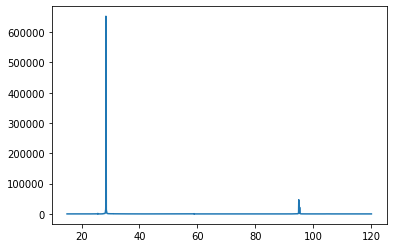

In [31]:
path =  'Data/SI_111_40_40_Ni.xy'
with open(path) as tf:
    data = np.loadtxt(tf,delimiter=" ").T

err = np.zeros(len(data[1]))
for i in range(len(err)):
    err[i] = (data[1,i])**0.5
data = np.vstack([data,err])
plt.plot(data[0],data[1])

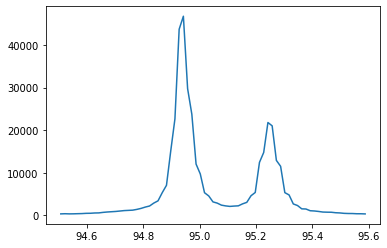

In [32]:
x=[[],[]]
for i in range(len(data[1])):
    if 94.5<data[0,i]<95.6:
        x[0].append(data[0,i])
        x[1].append(data[1,i])
plt.plot(x[0],x[1])

In [40]:
for i in range(len(data[0])):
    if data[0,i]>=95.5:
        print(i)
        break

5367


In [34]:
#modell erstellen a1 = [28.2,28.7]->[880,913]    
model_voigt = lmfit.model.Model(voigt2)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0.004,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
pars_voigt["s2"].set(value=0.0147,min=0,max=1)
pars_voigt["g2"].set(value=0.0147,min=0,max=1)
pars_voigt["o1"].set(value=28.4,min=28,max=29)
pars_voigt["o2"].set(value=28.5,min=28,max=29)
pars_voigt["scale1"].set(25000)
pars_voigt["scale2"].set(15000)
pars_voigt["c"].set(1)
 
#Fitten
out_voigt = model_voigt.fit(data[1,880:913],x=data[0,880:913],params=pars_voigt,weights=1/data[2,880:913],nan_policy='propagate')
a1f=out_voigt.fit_report()
a1p=np.array([np.arange(28.2,28.7,0.001),out_voigt.eval(x=np.arange(28.2,28.7,0.001))])


print('height1,underground1,signalnoiseratio1,height2,underground2,signalnoiseratio2')
print(SNR(out_voigt)[0].format(":1.5"))
print(SNR(out_voigt)[1].format(":1.5"))
print(SNR(out_voigt)[2].format(":1.5"))
print(SNR(out_voigt)[3].format(":1.5"))
print(SNR(out_voigt)[4].format(":1.5"))
print(SNR(out_voigt)[5].format(":1.5"))





height1,underground1,signalnoiseratio1,height2,underground2,signalnoiseratio2
7.8988e+05+/-0.8671e+05
4332.1+/-806.0
22.609+/-0.934
3.1003e+05+/-0.4347e+05
4332.1+/-806.0
18.547+/-1.003


In [35]:
#modell erstellen a2 = [58.7,59.1]->[2913,2940]     
model_voigt = lmfit.model.Model(voigt2)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
pars_voigt["s2"].set(value=0.0147,min=0.01,max=1)
pars_voigt["g2"].set(value=0.00147,min=0,max=1)
pars_voigt["o1"].set(value=58.8,min=58.7,max=58.85)
pars_voigt["o2"].set(value=58.98,min=58.9,max=59)
pars_voigt["scale1"].set(25000)
pars_voigt["scale2"].set(15000)
pars_voigt["c"].set(1)
 
#Fitten
out_voigt = model_voigt.fit(data[1,2913:2940],x=data[0,2913:2940],params=pars_voigt,weights=1/data[2,2913:2940],nan_policy='propagate')
a2f=out_voigt.fit_report()
a2p=np.array([np.arange(58.7,59.1,0.001),out_voigt.eval(x=np.arange(58.7,59.1,0.001))])



print('height1,underground1,signalnoiseratio1,height2,underground2,signalnoiseratio2')
print(SNR(out_voigt)[0].format(":1.5"))
print(SNR(out_voigt)[1].format(":1.5"))
print(SNR(out_voigt)[2].format(":1.5"))
print(SNR(out_voigt)[3].format(":1.5"))
print(SNR(out_voigt)[4].format(":1.5"))
print(SNR(out_voigt)[5].format(":1.5"))





height1,underground1,signalnoiseratio1,height2,underground2,signalnoiseratio2
859.58+/-125.57
15.985+/-6.287
17.306+/-1.792
410.07+/-97.71
15.985+/-6.287
14.091+/-1.939


In [42]:
#modell erstellen a3 = [94.7,95.5]->[5313,5367]       
model_voigt = lmfit.model.Model(voigt2)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0.009,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
pars_voigt["s2"].set(value=0.0147,min=0.009,max=1)
pars_voigt["g2"].set(value=0.0147,min=0,max=1)
pars_voigt["o1"].set(value=94.8,min=94,max=96)
pars_voigt["o2"].set(value=95.25,min=94,max=96)
pars_voigt["scale1"].set(25000)
pars_voigt["scale2"].set(15000)
pars_voigt["c"].set(1)
 
#Fitten
out_voigt = model_voigt.fit(data[1,5313:5367],x=data[0,5313:5367],params=pars_voigt,weights=1/data[2,5313:5367],nan_policy='propagate')
a3f=out_voigt.fit_report()
a3p=np.array([np.arange(94.7,95.5,0.001),out_voigt.eval(x=np.arange(94.7,95.5,0.001))])


print('height1,underground1,signalnoiseratio1,height2,underground2,signalnoiseratio2')
print(SNR(out_voigt)[0].format(":1.5"))
print(SNR(out_voigt)[1].format(":1.5"))
print(SNR(out_voigt)[2].format(":1.5"))
print(SNR(out_voigt)[3].format(":1.5"))
print(SNR(out_voigt)[4].format(":1.5"))
print(SNR(out_voigt)[5].format(":1.5"))



height1,underground1,signalnoiseratio1,height2,underground2,signalnoiseratio2
46489+/-3014
219.80+/-121.95
23.253+/-2.415
21127+/-3069
219.80+/-121.95
19.828+/-2.467


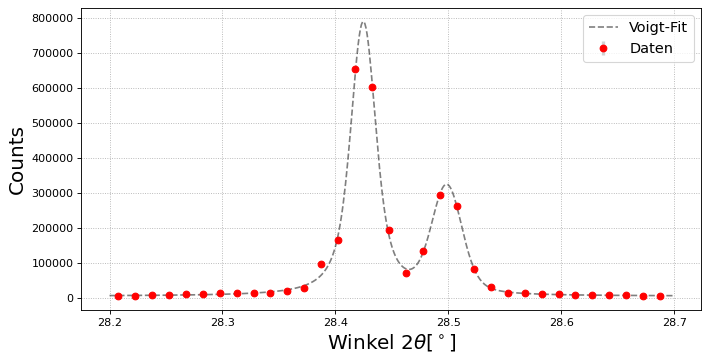

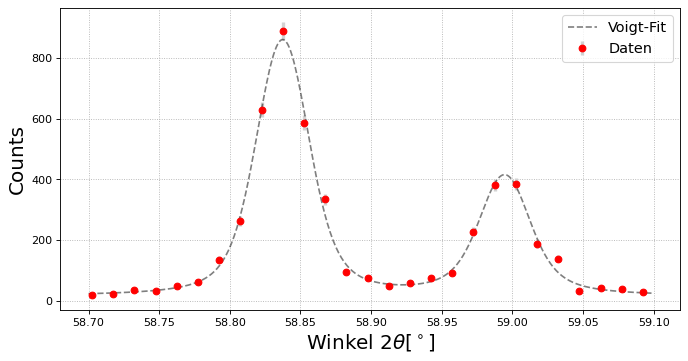

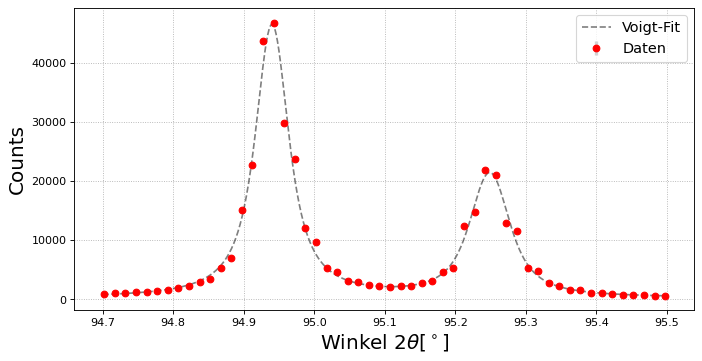

In [43]:


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,880:913],data[1,880:913],yerr=data[2,880:913],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
#plt.plot(np.arange(28.2,28.7,0.01),wlin(np.arange(28.2,28.7,0.01),b1,c1))
plt.plot(a1p[0],a1p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)





fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,2913:2940],data[1,2913:2940],yerr=data[2,2913:2940],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(a2p[0],a2p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)






fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,5313:5367],data[1,5313:5367],yerr=data[2,5313:5367],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(a3p[0],a3p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)


In [38]:

print('a1#######################################')
print(a1f)

print('a2#######################################')
print(a2f)

print('a3#######################################')
print(a3f)

a1#######################################
[[Model]]
    Model(voigt2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 113
    # data points      = 33
    # variables        = 9
    chi-square         = 21454.8950
    reduced chi-square = 893.953959
    Akaike info crit   = 231.747618
    Bayesian info crit = 245.216186
[[Variables]]
    s1:      0.00687796 +/- 0.00139496 (20.28%) (init = 0.0137)
    s2:      0.01126556 +/- 0.00138116 (12.26%) (init = 0.0147)
    g1:      0.00841891 +/- 9.6293e-04 (11.44%) (init = 0.0137)
    g2:      0.00475520 +/- 0.00167522 (35.23%) (init = 0.0147)
    o1:      28.4246507 +/- 3.5733e-04 (0.00%) (init = 28.4)
    o2:      28.4985924 +/- 6.4603e-04 (0.00%) (init = 28.5)
    scale1:  28851.9771 +/- 841.030141 (2.91%) (init = 25000)
    scale2:  11734.4699 +/- 611.068334 (5.21%) (init = 15000)
    c:       4332.14779 +/- 805.970199 (18.60%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(s1, g1)       